### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [31]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [32]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [33]:
duration = data.duration # duration of the time series data
print(duration)

sampling_rate = data.sample_rate # samples per second
print(sampling_rate)

n_points = len(data) # number of points in the sample
print(n_points)

delta_t = 1/sampling_rate # time resolution is 1/sampling rate
print(delta_t)

delta_f = 1/duration # duration is 1/duration
print(delta_f)

32.0
4096.0
131072
0.000244140625
0.03125


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

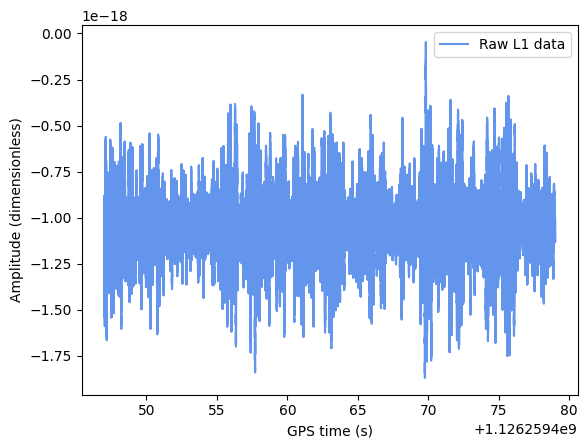

In [34]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

Text(0, 0.5, 'psd')

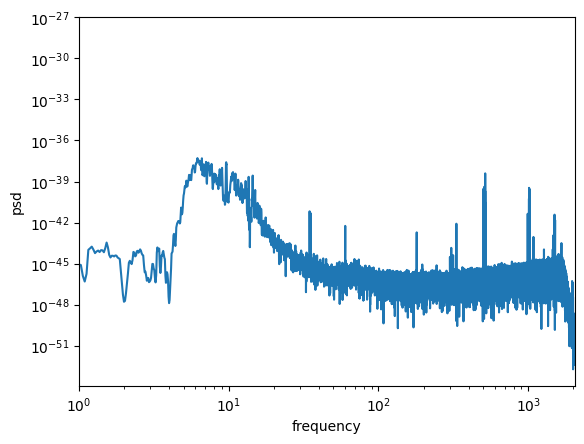

In [35]:
# psd is power spectral density gives the power dect

min_freq = 1 # minimum frequency (which is also flow in filter_psd)

nyquist_frequency = sampling_rate /2

psd = data.filter_psd(segment_duration = duration, delta_f = delta_f, flow = 1)

frequencies = psd.sample_frequencies

plt.figure()
plt.loglog(frequencies, psd) # to see all the frequencies at once and not have the lower freq dominate on the graph
plt.xlim(1, nyquist_frequency)
plt.xlabel("frequency")
plt.ylabel("psd")


The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


Text(0.5, 1.0, 'PSD of data vs whitened data')

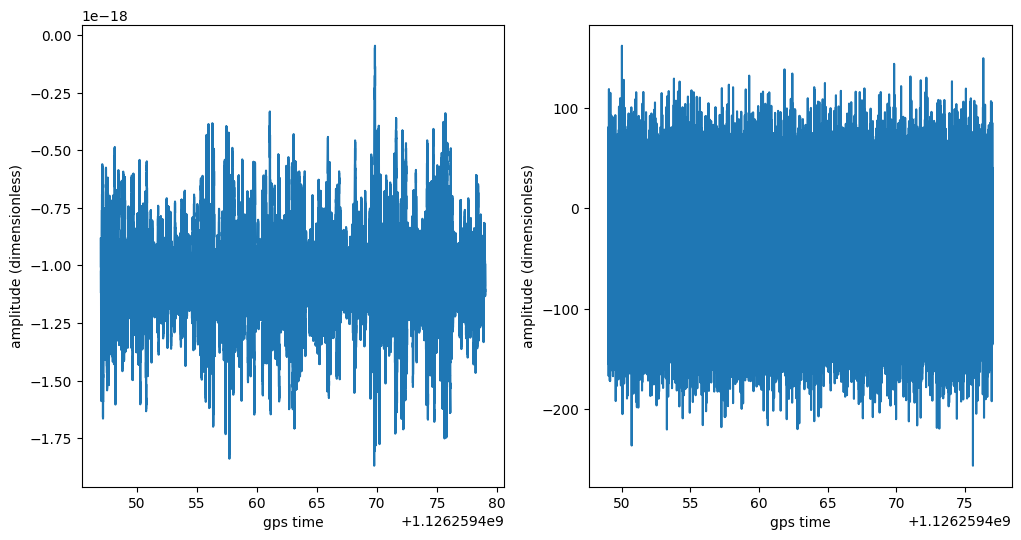

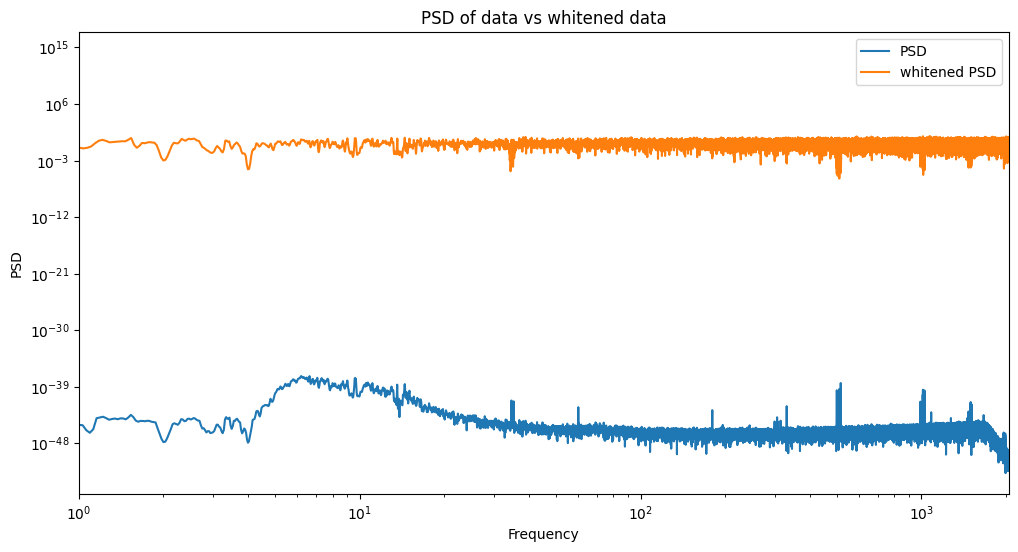

In [36]:
# Plot the whitened data next to the raw detector noise. What differences can you see?
#whitening: rescaling the data so that the signals are all uniform
white_data = data.whiten( segment_duration= 4, max_filter_duration= 4)
white_psd = white_data.filter_psd(white_data.duration, white_data.delta_f, flow = 1)

t = data.sample_times
t_white = white_data.sample_times

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(t, data, label = 'raw data')
plt.xlabel('gps time')
plt.ylabel('amplitude (dimensionless)')


plt.subplot(1,2,2)
plt.plot(t_white, white_data, label = 'whiten data')
plt.xlabel('gps time')
plt.ylabel('amplitude (dimensionless)')


# Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?

plt.figure(figsize=(12,6))
plt.loglog(psd.get_sample_frequencies(), psd, label="PSD")
plt.loglog(white_psd.get_sample_frequencies(), white_psd, label="whitened PSD")

plt.xlim(1, nyquist_frequency)
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.legend()
plt.title("PSD of data vs whitened data")





Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

Text(0.5, 1.0, 'Cropped bandpassed time series ')

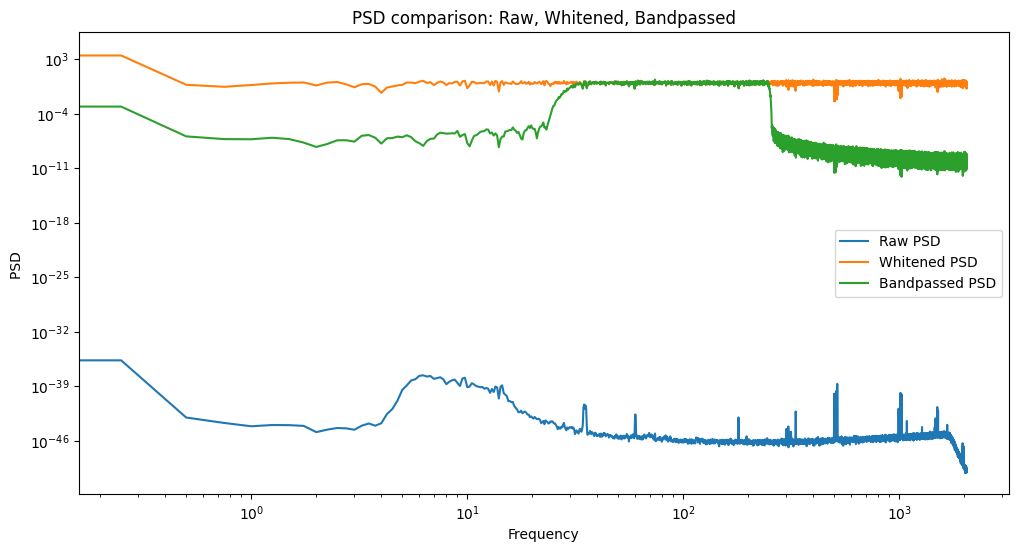

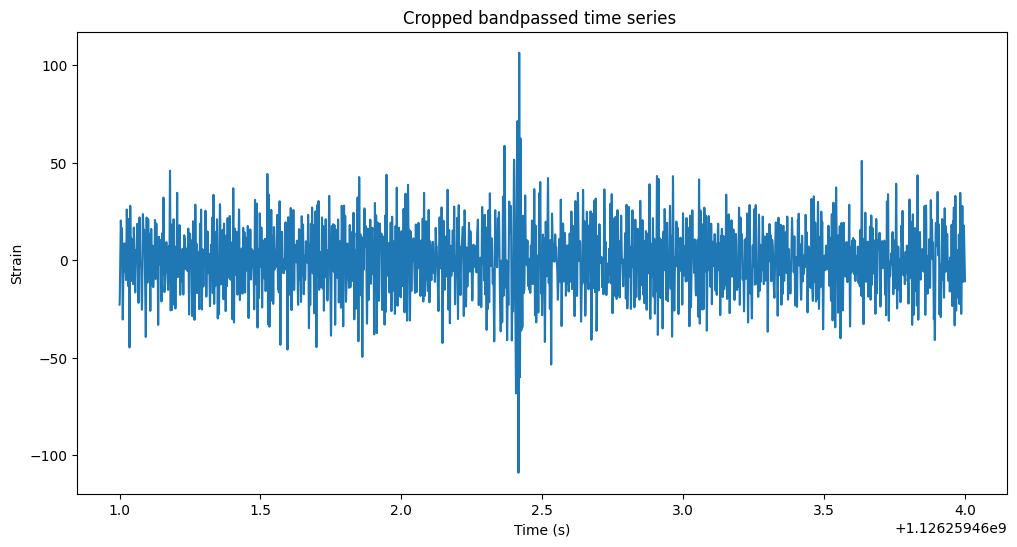

In [37]:
# we should use the whitened data here
#Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?
#band pass is keeping the frequencies between 30 and 250 hz

from pycbc.filter import highpass_fir, lowpass_fir

data_highpass = highpass_fir(white_data, 30 , order=512)
data_bandpass = lowpass_fir(data_highpass, 250 , order=512)

# PSDs
psd_raw = data.psd(segment_duration=4)
psd_white = white_data.psd(segment_duration=4)
psd_bandpass = data_bandpass.psd(segment_duration=4)

#ploting
plt.figure(figsize=(12,6))

plt.loglog(psd_raw.sample_frequencies, psd_raw, label="Raw PSD")
plt.loglog(psd_white.sample_frequencies, psd_white, label="Whitened PSD")
plt.loglog(psd_bandpass.sample_frequencies, psd_bandpass, label="Bandpassed PSD")

plt.xlabel("Frequency")
plt.ylabel("PSD ")
plt.title("PSD comparison: Raw, Whitened, Bandpassed")
plt.legend()

#Plot the bandpassed data cropping 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

t_start = data_bandpass.sample_times[0] + 12 # beginning of the time plus 12
t_end = data_bandpass.sample_times[-1] - 13  # minus 13 at the end

data_cropped = data_bandpass.time_slice(t_start, t_end) # crop data

#ploting
plt.figure(figsize=(12,6))
plt.plot(data_cropped.sample_times, data_cropped, label="Bandpassed data")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Cropped bandpassed time series ")

# normal raw data has low and high frequencies






**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

In [ ]:
# Generate spectrogram
t,f,p = data_bandpass.qtransform(delta_t=0.01, logfsteps=200, frange=(20, 512), qrange=(110, 110), mismatch=0.2, return_complex=False)

plt.pcolormesh(t[200:-200],f,p[:,200:-200]**0.5, vmax= 4)

plt.yscale('log')


As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Good job! This is the end of the second part. Maybe you can go for a break?